In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

# Gathering Data

Set up path to data folder

In [3]:
#shared_dir_path = os.environ["SHARED_DATA_DIR"] + '/'
shared_dir_path = '' # sub this out for above comment when using in notable
path = shared_dir_path + 'ESDA2_GroupProject_Data/'

Read in glacier area data

In [4]:
file = 'glacier_area.xlsx'
file_path = path + file
glacier_area = pd.read_excel(file_path)

Read in all weather station data

In [5]:
# bring in station data
file = '420800.csv'
file_path = path + file
station_420800 = pd.read_csv(file_path, delimiter=';')

file = '422100.csv'
file_path = path + file
station_422100 = pd.read_csv(file_path, delimiter=';')

file = '425000.csv'
file_path = path + file
station_425000 = pd.read_csv(file_path, delimiter=';')

file = '430100.csv'
file_path = path + file
station_430100 = pd.read_csv(file_path, delimiter=';')

file = '432000.csv'
file_path = path + file
station_432000 = pd.read_csv(file_path, delimiter=';')

file = '436000.csv'
file_path = path + file
station_436000 = pd.read_csv(file_path, delimiter=';')

file = 'station_details.xlsx'
file_path = path + file
station_details = pd.read_excel(file_path)

Read in SST data and separate into numpy arrays

In [6]:
file = 'HadISST_SST_northatlantic.nc'
file_path = path + file
ds = nc.Dataset(file_path)

sst_timedelta = ds.variables['time'][:]
sst_lat = ds.variables['latitude'][:]
sst_lon = ds.variables['longitude'][:]
sst = ds.variables['sst'][:,:,:]

We now have pandas dataframes or numpy arrays for all our variables

# Reformatting and Cleaning Data

Make the glacier area in to appropraite timeseries, and a dictionary of each glaciers lat and lon.

In [7]:
# make a df of each glaciers location
glacier_locations = glacier_area[['Glacier', 'Latitude', 'Longitude']].set_index('Glacier').T
glacier_locations = glacier_locations.rename(index={'Latitude': 'lat', 'Longitude': 'lon'})
glacier_locations = glacier_locations.to_dict()
print(glacier_locations['Rink Isbrae'])

{'lat': 71.73282971, 'lon': -51.6631661}


In [8]:
glacier_timeseries = glacier_area.drop(['Latitude', 'Longitude'], axis=1).set_index('Glacier').T
glacier_timeseries.index = pd.to_datetime(glacier_timeseries.index)
glacier_timeseries.head()

Glacier,Umiammakku Isbrae,Geikie Unnamed Vestford S,Rink Isbrae,Kangerlussuup Sermersua,Sermeq Silarleq,Cw Noname2,Lille Gletscher,Store Gletscher,Sermeq Avannarleq2,Narsap Sermia,...,Nordfjord,Styrte,Courtauld,Unnamed Deception N,Kruuse Fjord,Ice Caps Ce,Glacierdefrance,Knud-Rasmussen,Nigertuluup Kattilertarpia,Ice Caps Se
1972-09-15,2316.126692,2720.110833,30000.470567,7659.530459,12065.276036,2538.520698,2537.371493,30273.675460,7992.051332,6380.928283,...,346.096339,411.105516,187.707442,793.373169,1422.079573,7536.075193,385.250416,525.690781,343.936543,1945.481414
1972-10-15,2316.126692,2720.067640,30000.456019,7659.225421,12065.073406,2538.506235,2537.342593,30273.661026,7991.964906,6381.066998,...,346.096339,411.105516,187.793015,792.220908,1421.994782,7536.089455,385.250417,525.368253,343.908438,1944.808804
1972-11-15,2316.126692,2720.053243,30000.456019,7659.051114,12065.102360,2538.506235,2537.313692,30273.661026,7991.907289,6381.053125,...,346.096339,411.105516,187.793015,791.922177,1421.938222,7536.089455,385.264473,525.326185,343.880332,1944.752884
1972-12-15,2316.126692,2720.038846,30000.456019,7658.920384,12065.102376,2538.506235,2537.270346,30273.661026,7991.878480,6381.039252,...,346.096339,411.105516,187.793015,791.595001,1421.895802,7536.089455,385.264472,525.298139,343.852227,1944.724837
1973-01-15,2316.126692,2720.038846,30000.456019,7658.862281,12065.131331,2538.506235,2537.241445,30273.661026,7991.864075,6381.039252,...,346.096339,411.105516,187.793015,791.410075,1421.895802,7536.089455,385.264471,525.270093,343.838175,1944.724837


SST data is stored in 4 arrays: time, lats, lons, and sst. Time is stored as time since 1870-1-1 0:0:0. We will convert these times then to appropriate timestamps.

In [9]:
print(ds['time'])

<class 'netCDF4.Variable'>
float32 time(time)
    units: days since 1870-1-1 0:0:0
    calendar: gregorian
    long_name: Time
    standard_name: time
unlimited dimensions: 
current shape = (1856,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [10]:
sst_time = pd.to_timedelta(sst_timedelta, unit='D') + pd.Timestamp('1870-01-01 00:00:00')
print(sst_time)

DatetimeIndex(['1870-01-16 11:59:59.505615234',
               '1870-02-14 23:59:59.340820315',
               '1870-03-16 11:59:59.340820315',
               '1870-04-15 23:59:59.340820315',
                         '1870-05-16 12:00:00',
                         '1870-06-16 00:00:00',
                         '1870-07-16 12:00:00',
                         '1870-08-16 12:00:00',
                         '1870-09-16 00:00:00',
                         '1870-10-16 12:00:00',
               ...
                         '2023-11-16 00:00:00',
                         '2023-12-16 12:00:00',
                         '2024-01-16 12:00:00',
                         '2024-02-15 12:00:00',
                         '2024-03-16 12:00:00',
                         '2024-04-16 00:00:00',
                         '2024-05-16 12:00:00',
                         '2024-06-16 00:00:00',
                         '2024-07-16 12:00:00',
                         '2024-08-16 12:00:00'],
              dtype=

SST has a lot of masked values for values on land - the functions in the functions section allow us to pick a point closest to the glacier with data. However, at certain timestamps the SST is given as -1000 for different glaciers. Cleaning that we do:

In [11]:
mask_value = -1000.0
freezing_point = -1.8
sst[sst == mask_value] = freezing_point

Now we simplify our metdata for each station, and creat a dictionary to access

In [12]:
metdata_420800 = station_420800.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_420800['Date'] = pd.to_datetime(metdata_420800[['Year', 'Month', 'Day', 'Hour']])
metdata_420800 = metdata_420800.set_index('Date')
metdata_420800 = metdata_420800[['airtemp']]

metdata_422100 = station_422100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_422100['Date'] = pd.to_datetime(metdata_422100[['Year', 'Month', 'Day', 'Hour']])
metdata_422100 = metdata_422100.set_index('Date')
metdata_422100 = metdata_422100[['airtemp']]

metdata_425000 = station_425000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_425000['Date'] = pd.to_datetime(metdata_425000[['Year', 'Month', 'Day', 'Hour']])
metdata_425000 = metdata_425000.set_index('Date')
metdata_425000 = metdata_425000[['airtemp']]

metdata_430100 = station_430100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_430100['Date'] = pd.to_datetime(metdata_430100[['Year', 'Month', 'Day', 'Hour']])
metdata_430100 = metdata_430100.set_index('Date')
metdata_430100 = metdata_430100[['airtemp']]

metdata_432000 = station_432000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_432000['Date'] = pd.to_datetime(metdata_432000[['Year', 'Month', 'Day', 'Hour']])
metdata_432000 = metdata_432000.set_index('Date')
metdata_432000 = metdata_432000[['airtemp']]

metdata_436000 = station_436000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_436000['Date'] = pd.to_datetime(metdata_436000[['Year', 'Month', 'Day', 'Hour']])
metdata_436000 = metdata_436000.set_index('Date')
metdata_436000 = metdata_436000[['airtemp']]

metdata = {
    '420800': metdata_420800,
    '422100': metdata_422100,
    '425000': metdata_425000,
    '430100': metdata_430100,
    '432000': metdata_432000,
    '436000': metdata_436000
}

## Summary of Data

Glacier:
* glacier_timeseries - pandas DataFrame of all glaciers' area at different timestamps; find single glacier by indexing in with glacier_timeseries[GLACIER]
* glacier_locations - dict of glacier positions; lat = glacier_locations[GLACIER]['lat'], lon = glacier_locations[GLACIER]['lon']

Metdata:
* station_details - pandas DataFrame with information about each station (most crucially location); appropriate station chosen by functions below
* metdata_i (where i is station number) - pandas timeseries of airtemp at station i; note many na values (maintenance, etc) but not cleaned as different ways will be needed for different questions
* metdata - dict of all metdata_i; find station by metdata[STATION NUMBER], where appropriate station number can be found from function below

Sea Surface Temperture:
* sst_time - array of datetimes for sst data
* sst_lat - array of latitutdes of stt data
* sst_lon - array of longitudes of sst data
* sst - 3d array of sst; index in [ind_time, ind_lat, ind_lon]; choose lat and lon index by functions below

# Useful Functions

Function to find the index for the point of sst to glacier.

In [13]:
def pick_closest_SST(lats, lons, sst, glacier):
    """
    lats: 1D array of latitudes
    lons: 1D array of longitudes
    sst: 3D array of sea surface temp at (time, latitude, longitude)
    glacier: (lat, lon); a tuple of glacier coordinates

    returns: ind_lat, ind_lon -> indices to get sst data closest to glacier
    """
    sst_slice = sst[-1, :, :]   # last time step
    mask = sst_slice.mask
    
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    dist = np.sqrt((lat2d - glacier[0])**2 + (lon2d - glacier[1])**2)

    dist_masked = np.ma.array(dist, mask=mask)

    pair = np.unravel_index(np.argmin(dist_masked), dist_masked.shape)

    ind_lat = pair[0]
    ind_lon = pair[1]
    
    return ind_lat, ind_lon

In [14]:
GLACIER = 'Rink Isbrae'
target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
print(ind_lat, ind_lon)
print(sst[:, ind_lat, ind_lon])


18 46
[-1.5146484375 -1.72021484375 -1.7999999523162842 ... 2.065570116043091
 2.2367069721221924 4.495405673980713]


Function to find closest air temp reading to glacier.

In [15]:
def pick_closest_airtemp(station_details, glacier_location):
    """
    station_details: dataframe with columns 'Station Code', 'Latitude', 'Longitude'
    target_lat: latitude of glacier
    target_lon: longitude of glacier

    returns: station_code -> code of closest station
    """
    target_lat, target_lon = glacier_location
    lats = station_details['Latitude'].values
    lons = station_details['Longitude'].values
    station_codes = station_details['Station number'].values

    dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)

    min_index = np.argmin(dist)

    station_number = station_codes[min_index]

    return station_number   

In [16]:
GLACIER = 'Rink Isbrae'
target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])

station_number = pick_closest_airtemp(station_details, target_location)
print(station_number)

422100


# Getting DataFrames together

In [17]:
def get_glacier_df(GLACIER, SAMPLE_TIME):

    target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])

    # get data from closest met station
    station_number = pick_closest_airtemp(station_details, target_location)
    glacier_metdata = metdata[str(station_number)]

    # take only year where we have data for all months - avoids bias from missing months, as temp varies seasonally
    glacier_metdata = glacier_metdata[~glacier_metdata['airtemp'].isna()]
    months_per_year = glacier_metdata.groupby(glacier_metdata.index.year).apply(lambda x: x.index.month.nunique())
    valid_years = months_per_year[months_per_year == 12].index
    glacier_metdata = glacier_metdata[glacier_metdata.index.year.isin(valid_years)]

    # get SST data from closest grid point and convert to time series
    ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
    glacier_sst = sst[:, ind_lat, ind_lon]
    glacier_sst = pd.DataFrame({'Date': sst_time, 'SST': glacier_sst})
    glacier_sst = glacier_sst.set_index('Date')

    # align time series to common start date
    start = max(glacier_timeseries.index[0], glacier_metdata.index[0], glacier_sst.index[0])

    glacier_area_series = glacier_timeseries[GLACIER][glacier_timeseries.index >= start]
    glacier_metdata_series = glacier_metdata[glacier_metdata.index >= start]
    glacier_sst_series = glacier_sst[glacier_sst.index >= start]

    # resample time series
    glacier_area_resampled = glacier_area_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_metdata_resampled = glacier_metdata_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_sst_resampled = glacier_sst_series.resample(SAMPLE_TIME).mean().dropna()

    # join time series into single dataframe
    glacier_df = pd.concat([glacier_area_resampled, glacier_metdata_resampled, glacier_sst_resampled], axis=1, join='inner')
    glacier_df = glacier_df.rename(columns={GLACIER: 'area'})
    
    return glacier_df

In [18]:
GLACIER = 'Rink Isbrae'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)
glacier_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 1972-12-31 to 2022-12-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   area     50 non-null     float64
 1   airtemp  50 non-null     float64
 2   SST      50 non-null     float32
dtypes: float32(1), float64(2)
memory usage: 1.4 KB


# Basic Timeseries Plots 

One for each variable, can specify glacier, and time parameters.

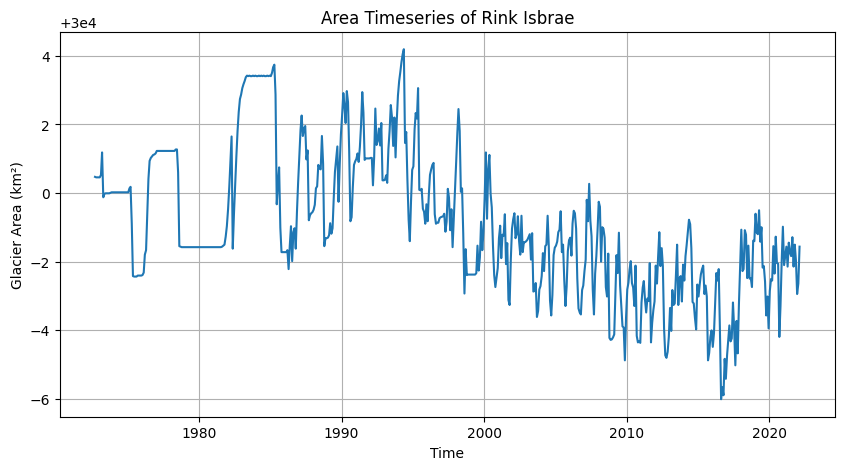

In [19]:
# Glacier Area Time Series Plot for glacier of choice with time restriction
GLACIER = 'Rink Isbrae'
START_TIME = '1970-01-01'
END_TIME = '2025-12-31'

restricted_time = (glacier_timeseries.index >= START_TIME) & (glacier_timeseries.index <= END_TIME)
glacier_area_plot = glacier_timeseries.loc[restricted_time, GLACIER]

plt.figure(figsize=(10,5))
plt.plot(glacier_area_plot.index, glacier_area_plot)
plt.title(f'Area Timeseries of {GLACIER}')
plt.xlabel('Time')
plt.ylabel('Glacier Area (km²)')
plt.grid()
plt.show()

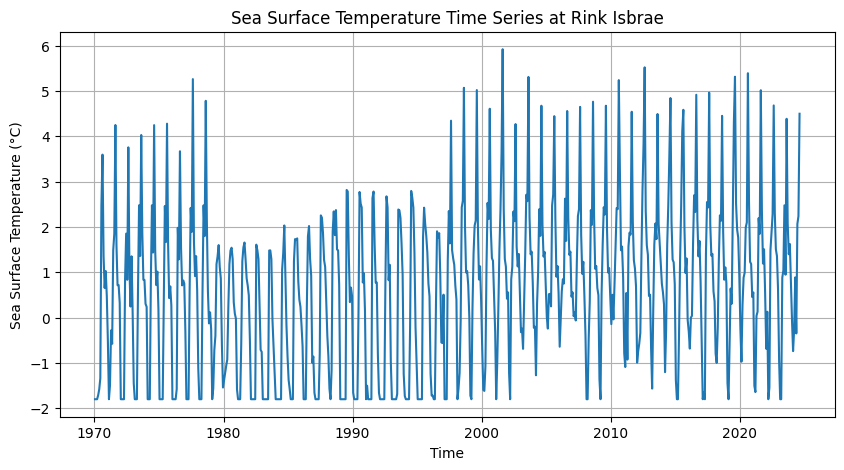

In [20]:
# SST Time Series Plot for glacier of choice, with time restriction
GLACIER = 'Rink Isbrae'
START_TIME = '1970-01-01'
END_TIME = '2025-12-31'

target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
glacier_sst = sst[:, ind_lat, ind_lon]

restricted_time = (sst_time >= START_TIME) & (sst_time <= END_TIME)
sst_time_plot = sst_time[restricted_time]
glacier_sst_plot = glacier_sst[restricted_time]

plt.figure(figsize=(10,5))
plt.plot(sst_time_plot, glacier_sst_plot)
plt.title(f'Sea Surface Temperature Time Series at {GLACIER}')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid()
plt.show()

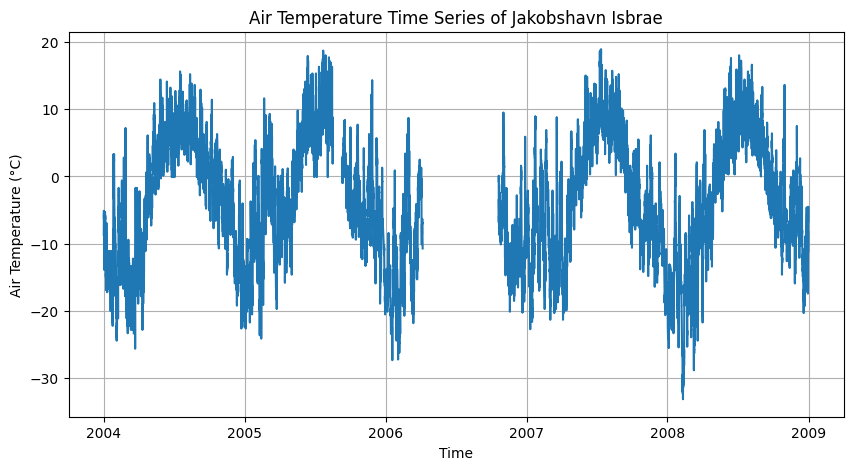

In [21]:
# Airtemp Time Series Plot for glacier of choice with time restriction
GLACIER = 'Jakobshavn Isbrae'
START_TIME = '2004-01-01'
END_TIME = '2008-12-31'

target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
station_number = pick_closest_airtemp(station_details, target_location)
airtemp_data = metdata[str(station_number)]

restricted_time = (airtemp_data.index >= START_TIME) & (airtemp_data.index <= END_TIME)
airtemp_plot = airtemp_data.loc[restricted_time]

plt.figure(figsize=(10,5))
plt.plot(airtemp_plot.index, airtemp_plot['airtemp'])
plt.title(f'Air Temperature Time Series of {GLACIER}')
plt.xlabel('Time')
plt.ylabel('Air Temperature (°C)')
plt.grid()
plt.show()

# Resampled Plots

From glacier data, plots for time series over resample time, and regression plot for 2 varibles over a resample time. 

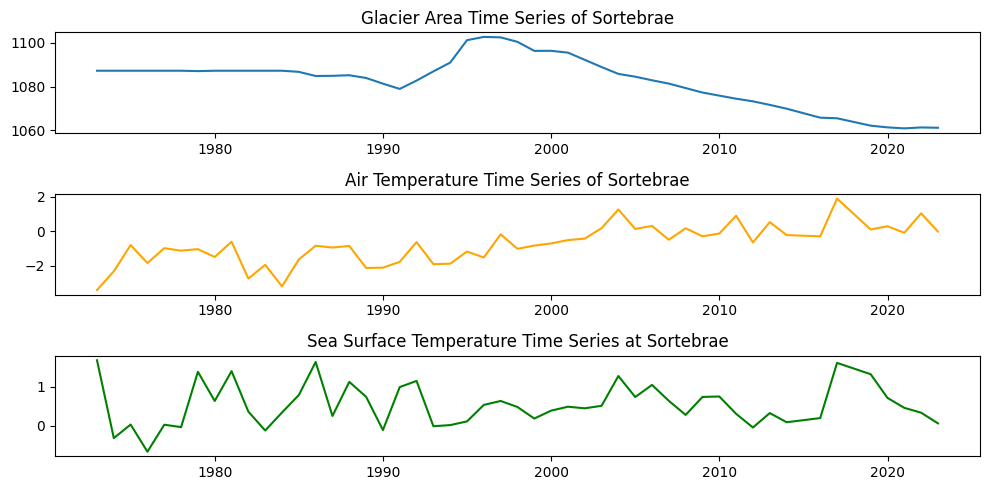

In [22]:
GLACIER = 'Sortebrae'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(glacier_df.index, glacier_df['area'])
ax[0].set_title(f'Glacier Area Time Series of {GLACIER}')
ax[1].plot(glacier_df.index, glacier_df['airtemp'], color='orange')
ax[1].set_title(f'Air Temperature Time Series of {GLACIER}')
ax[2].plot(glacier_df.index, glacier_df['SST'], color='green')
ax[2].set_title(f'Sea Surface Temperature Time Series at {GLACIER}')
plt.tight_layout()
plt.show()


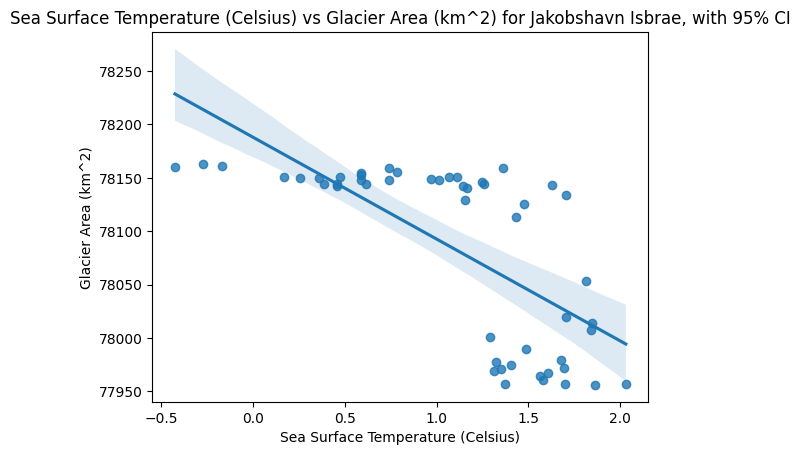

In [23]:
GLACIER = 'Jakobshavn Isbrae'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'
X = 'SST'
Y = 'area'

labels = {'airtemp': 'Air Temperature (Celsius)',
    'SST': 'Sea Surface Temperature (Celsius)',
    'area': 'Glacier Area (km^2)'}
glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

# make regression plot with 95% confidence interval
sns.regplot(x=X, y=Y, data=glacier_df, ci=95)
plt.xlabel(labels[X])
plt.ylabel(labels[Y])
plt.title(f'{labels[X]} vs {labels[Y]} for {GLACIER}, with 95% CI')
plt.show()

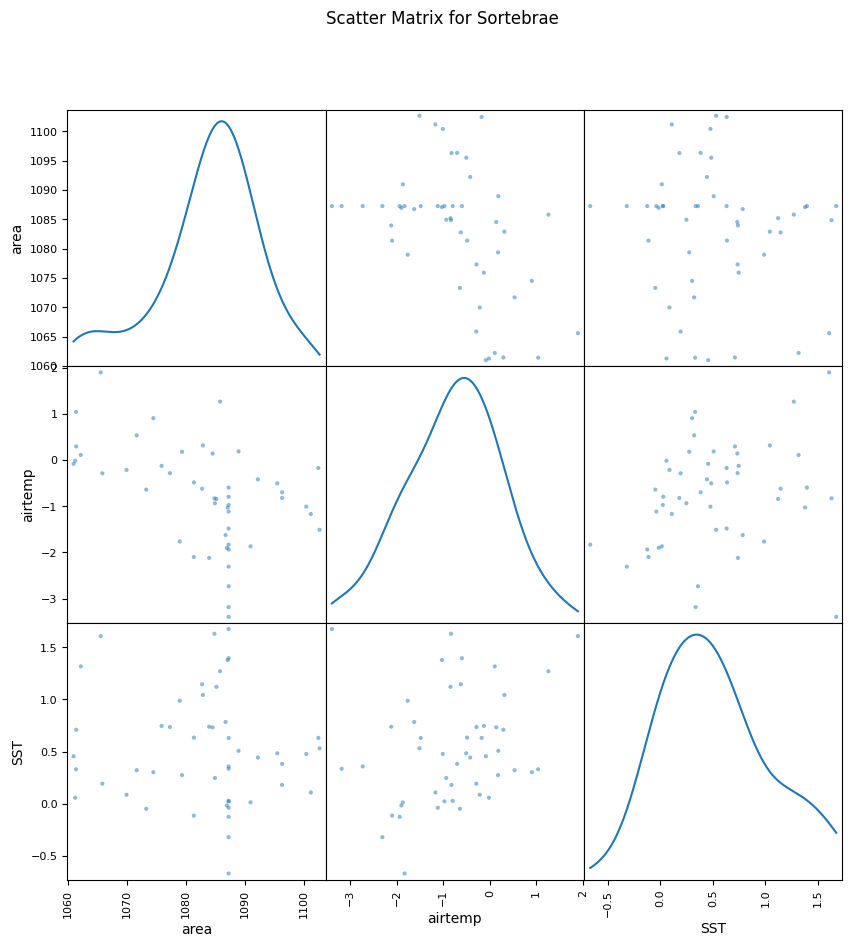

In [24]:
GLACIER = 'Sortebrae'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

pd.plotting.scatter_matrix(glacier_df, figsize=(10,10), diagonal='kde')
plt.suptitle(f'Scatter Matrix for {GLACIER}')
plt.show()

# Maps and Data onto Maps

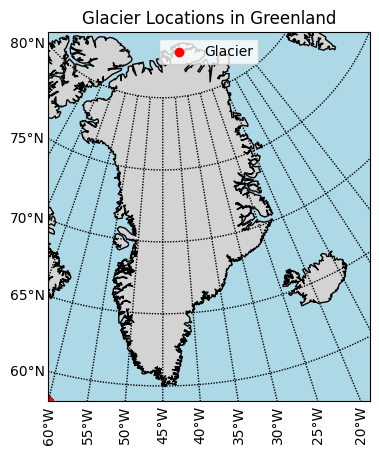

In [25]:
#  create basemap
map = Basemap(projection='stere', lat_0=70, lon_0=-45, lat_ts=70, llcrnrlat=58, llcrnrlon=-60, urcrnrlat=75, urcrnrlon=25, resolution='l')
map.drawcoastlines()
# shade land and ocean
map.drawlsmask(land_color='lightgrey', ocean_color='lightblue')
# add lines of latitude
map.drawparallels(np.arange(55, 90, 5),labels=[1,0,0,0])
# add lines of longitude
map.drawmeridians(np.arange(-75, 0, 5),labels=[0,0,0,1], rotation=90)
# show plot
longitudes = [glacier_locations[key]['lon'] for key in glacier_locations]
latitudes = [glacier_locations[key]['lat'] for key in glacier_locations]

map.scatter(longitudes, latitudes, color='r', marker='o', label='Glacier')
plt.xticks(rotation=90)
plt.title('Glacier Locations in Greenland')
plt.legend()
plt.show()

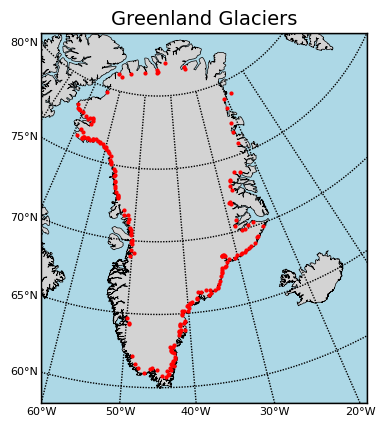

In [26]:
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# add glaciers
lons = [glacier_locations[key]['lon'] for key in glacier_locations]
lats = [glacier_locations[key]['lat'] for key in glacier_locations]
x, y = m(lons, lats)

# Plot the points
m.plot(x, y, 'ro', markersize=2, label='Locations')

plt.title('Greenland Glaciers', fontsize=14)
plt.show()

Above map scaled to maximum relative area loss:

C:\Users\JoelM\AppData\Local\Temp\ipykernel_32772\162607829.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([new_row])], ignore_index=True)


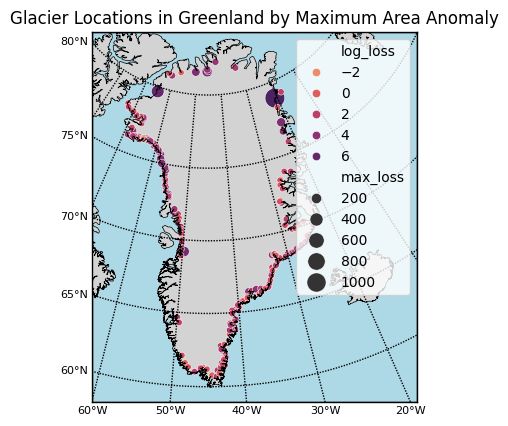

In [27]:
# set up map projection
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# calculate relative area loss for all glaciers
area_anomaly = (glacier_timeseries - glacier_timeseries.iloc[0])
max_area_anomaly = - area_anomaly.min()

# create a dataframe for plotting of glacier xy locations and max relative loss
plot_df = pd.DataFrame(columns=['glacier', 'x', 'y', 'max_loss', 'log_loss', 'rel_loss'])
for glacier in glacier_locations:
    lat = glacier_locations[glacier]['lat']
    lon = glacier_locations[glacier]['lon']
    x, y = m(lon, lat)
    max_loss = max_area_anomaly[glacier]
    rel_loss = max_loss / glacier_timeseries[glacier].iloc[0]
    log_loss = np.log(max_loss) if max_loss > 0 else 0
    new_row = {'glacier': glacier, 'x': x, 'y': y, 'max_loss': max_loss, 'log_loss': log_loss, 'rel_loss': rel_loss}
    plot_df = pd.concat([plot_df, pd.DataFrame([new_row])], ignore_index=True)

plot_df.set_index('glacier', inplace=True)

sns.scatterplot(data=plot_df, x='x', y='y', size='max_loss', sizes=(20,200), hue='log_loss', palette='flare', legend=True)
plt.title('Glacier Locations in Greenland by Maximum Area Anomaly')
plt.show()

# Sheet 1 Visualisations

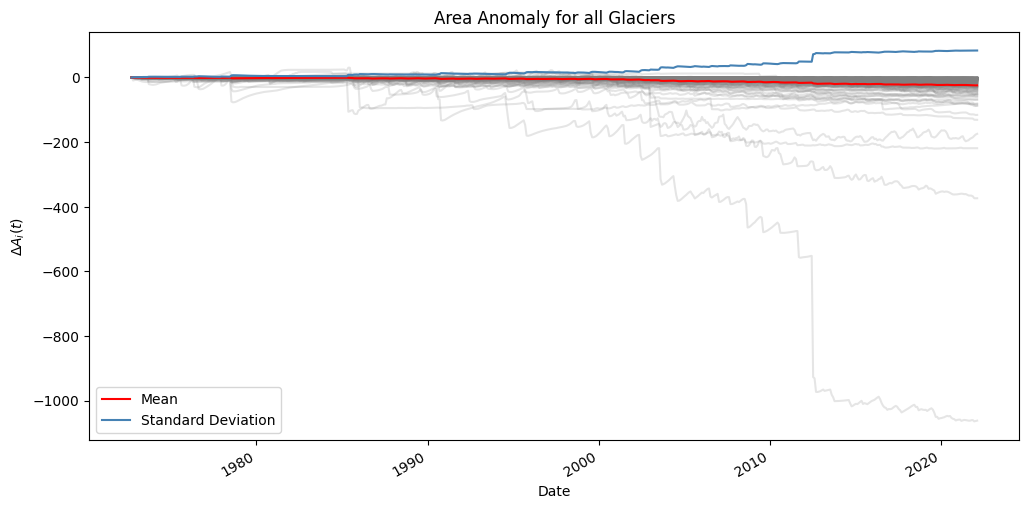

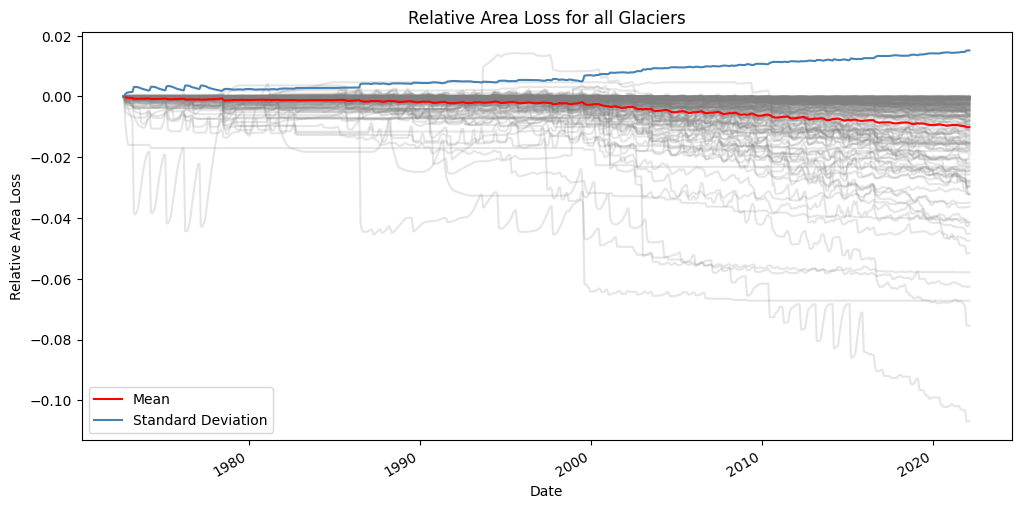

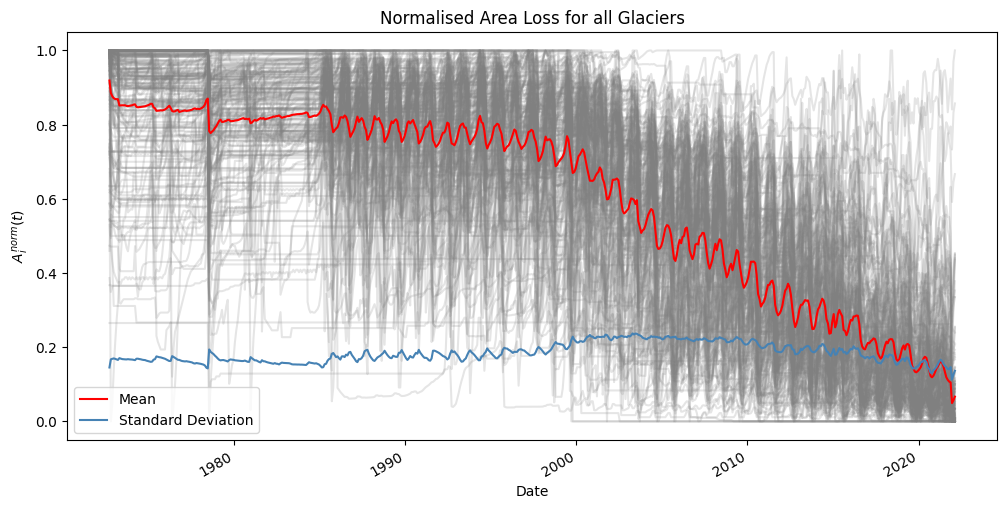

In [28]:
# AREA ANOMALY
# caclulate area anomaly
delta_df = glacier_timeseries - glacier_timeseries.iloc[0]

# plot area anomaly for all glaciers 
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for glacier in delta_df:
    delta_df[glacier].plot(ax=ax, color='gray', alpha=0.2, label='_nolegend_')

# caclulate mean and std
delta_df["mean"] = delta_df.mean(axis=1)
delta_df["std"] = delta_df.std(axis=1)

# plot mean and std
delta_df['mean'].plot(ax=ax, label='Mean', color='red')
delta_df['std'].plot(ax=ax, label='Standard Deviation', color='steelblue')

# customise graph
ax.set_xlabel('Date')
ax.set_ylabel(r"$\Delta A_i (t)$")
ax.set_title('Area Anomaly for all Glaciers')
plt.legend()
plt.show()

# RELATIVE AREA LOSS
# caclulate relative loss
rel_loss_df = delta_df / glacier_timeseries.iloc[0]

# plot relative loss for all glaciers
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for glacier in rel_loss_df:
    rel_loss_df[glacier].plot(ax=ax, color='gray', alpha=0.2, label='_nolegend_')

# caclulate mean and std
rel_loss_df["mean"] = rel_loss_df.mean(axis=1)
rel_loss_df["std"] = rel_loss_df.std(axis=1)

# plot mean and std
rel_loss_df['mean'].plot(ax=ax, label='Mean', color='red')
rel_loss_df['std'].plot(ax=ax, label='Standard Deviation', color='steelblue')

# customise graph
ax.set_xlabel('Date')
ax.set_ylabel('Relative Area Loss')
ax.set_title('Relative Area Loss for all Glaciers')
plt.legend()
plt.show()

# NORMALISED AREA LOSS
# calculate normalised loss
norm_loss_df = (glacier_timeseries - glacier_timeseries.min())/(glacier_timeseries.max() - glacier_timeseries.min())

# plot normalised loss for all glaciers
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for glacier in norm_loss_df:
    norm_loss_df[glacier].plot(ax=ax, color='gray', alpha=0.2, label='_nolegend_')

# caclulate mean and std
norm_loss_df["mean"] = norm_loss_df.mean(axis=1)
norm_loss_df["std"] = norm_loss_df.std(axis=1)

# plot mean and std
norm_loss_df['mean'].plot(ax=ax, label='Mean', color='red')
norm_loss_df['std'].plot(ax=ax, label='Standard Deviation', color='steelblue')

# customise graph
ax.set_xlabel('Date')
ax.set_ylabel(r"$A_i ^{norm} (t)$")
ax.set_title('Normalised Area Loss for all Glaciers')
plt.legend()
plt.show()

In [29]:
diffs = glacier_timeseries.iloc[-1] - glacier_timeseries.iloc[0] 
increases = diffs[diffs > 0]

print(increases)
print(diffs.sort_values(ascending=True))

Glacier
Qajuuttap Sermia     1.308321
Heimdal Gletscher    0.410134
dtype: float64
Glacier
Zachariae Isstrom     -1062.119518
Humboldt Gletscher     -373.745155
Ostenfeld Gletscher    -218.908576
Jakobshavn Isbrae      -174.449521
Storstrommen           -131.027955
                          ...     
Store Gletscher          -0.202197
Mohn Gletsjer            -0.178526
Nw Noname3               -0.029753
Heimdal Gletscher         0.410134
Qajuuttap Sermia          1.308321
Length: 195, dtype: float64


# Sheet 2 Visualisations

# Sheet 3 Visualisations

# Time of Multiple Glacier Retreat

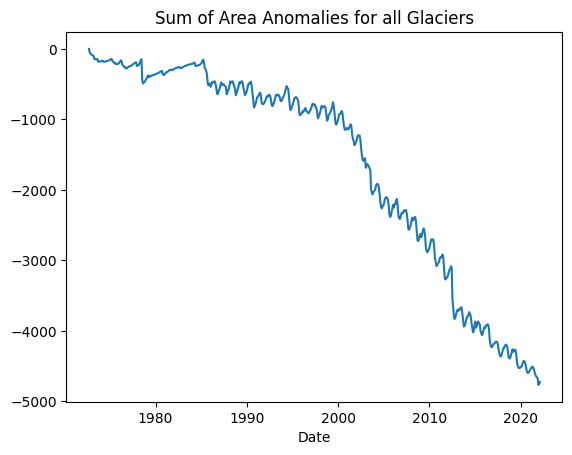

In [30]:
# Area Anomaly
# calculate area anomaly
delta_df = glacier_timeseries - glacier_timeseries.iloc[0]

plt.plot(delta_df.index, delta_df.sum(axis=1))
plt.title('Sum of Area Anomalies for all Glaciers')
plt.xlabel('Date')
plt.show()

# look at rate of change from here to see drop?

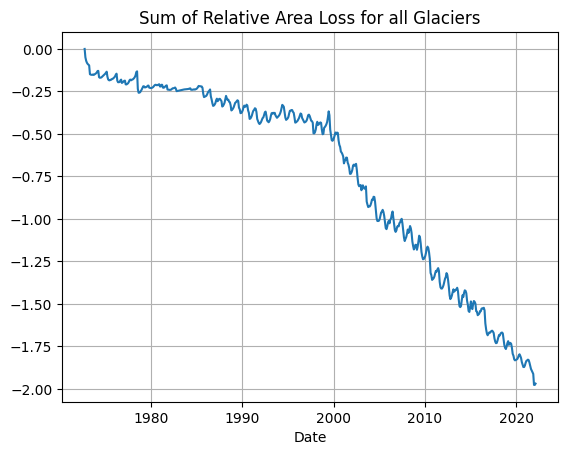

In [31]:
# Relative Area Loss
# calculate relative loss
delta_df = glacier_timeseries - glacier_timeseries.iloc[0]
relative_loss = delta_df / glacier_timeseries.iloc[0] 

plt.plot(relative_loss.index, relative_loss.sum(axis=1))
plt.title('Sum of Relative Area Loss for all Glaciers')
plt.xlabel('Date')
plt.grid()
plt.show()

# look at rate of change from here to see drop?
# corner point just before 2000?

# Question 1

# Quesiton 2

# Question 3

Text(0.5, 1.0, 'Sea Surface Temperature Yearly Averages at Rink Isbrae')

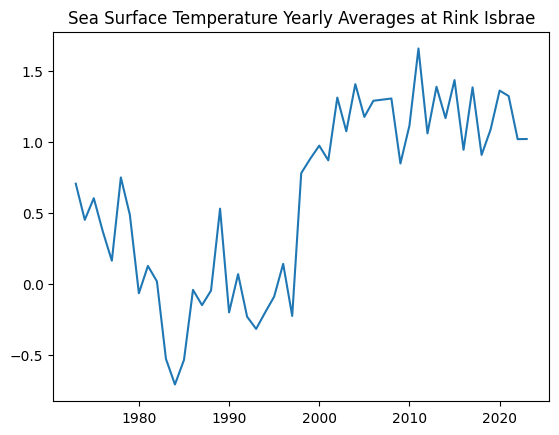

In [32]:
GLACIER = 'Rink Isbrae'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5
START_TIME = '1970-01-01'
END_TIME = '2025-12-31'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

restricted_time = (glacier_df.index >= START_TIME) & (glacier_df.index <= END_TIME)
x = glacier_df.loc[restricted_time]
y = glacier_df.loc[restricted_time, 'SST']

plt.plot(x.index, y)
plt.title(f'Sea Surface Temperature Yearly Averages at {GLACIER}')

# Question 4

# Question 5



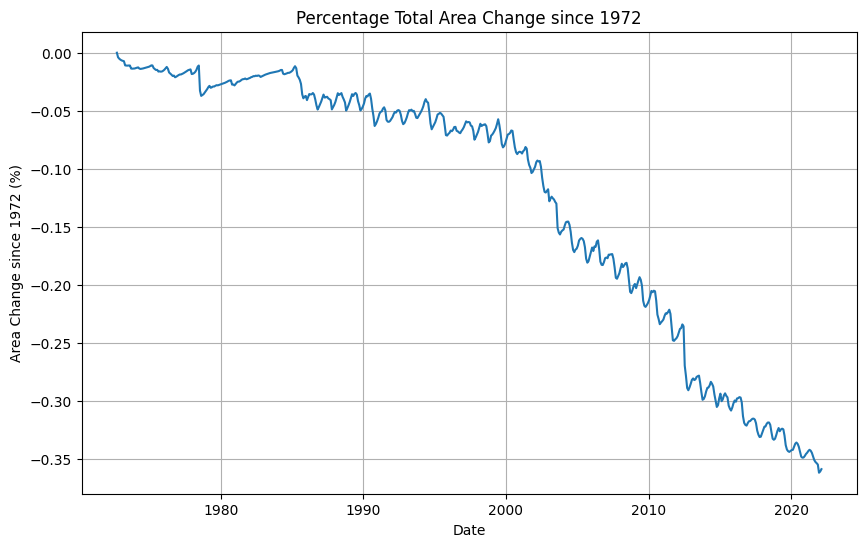

In [124]:
# calculate percentage loss
sum_areas = glacier_timeseries.sum(axis=1)
pct_loss = (sum_areas - sum_areas.iloc[0]) / sum_areas.iloc[0] * 100 # percentage

# plot percentage loss
plt.figure(figsize=(10,6))
plt.plot(pct_loss.index, pct_loss)
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972')
plt.grid()
plt.show()


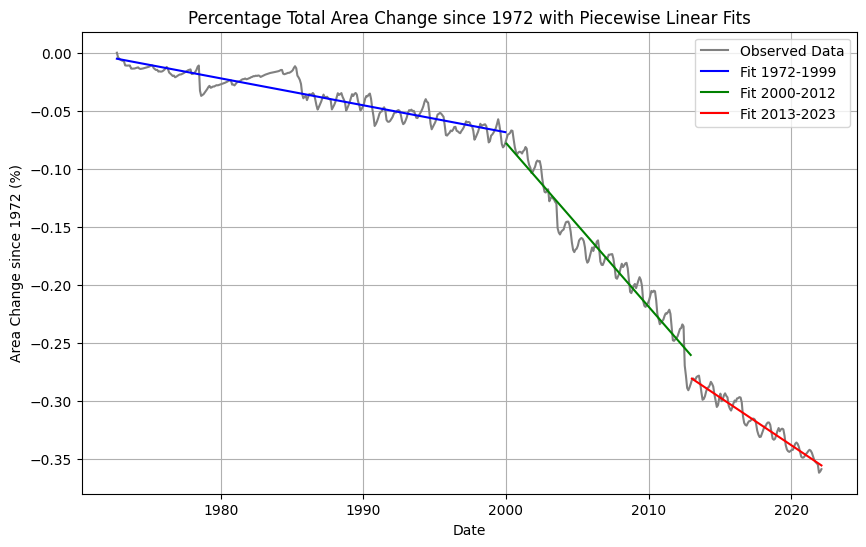

In [125]:
# split into 3 distinct sections based on visual inspection
pct_loss_1972_1999 = pct_loss[(pct_loss.index < '2000-01-01')]
pct_loss_2000_2012 = pct_loss[(pct_loss.index >= '2000-01-01') & (pct_loss.index < '2013-01-01')]
pct_loss_2013_2023 = pct_loss[pct_loss.index >= '2013-01-01']

# fit linear to each section
m1, b1 = np.polyfit(mdates.date2num(pct_loss_1972_1999.index), pct_loss_1972_1999.values, 1)
m2, b2 = np.polyfit(mdates.date2num(pct_loss_2000_2012.index), pct_loss_2000_2012.values, 1)
m3, b3 = np.polyfit(mdates.date2num(pct_loss_2013_2023.index), pct_loss_2013_2023.values, 1)

# plot each section with its fit
plt.figure(figsize=(10,6))
plt.plot(relative_loss.index, relative_loss, label='Observed Data', color='grey')
plt.plot(pct_loss_1972_1999.index, m1*mdates.date2num(pct_loss_1972_1999.index) + b1, color='blue', label='Fit 1972-1999')
plt.plot(pct_loss_2000_2012.index, m2*mdates.date2num(pct_loss_2000_2012.index) + b2, color='green', label='Fit 2000-2012')
plt.plot(pct_loss_2013_2023.index, m3*mdates.date2num(pct_loss_2013_2023.index) + b3, color='red', label='Fit 2013-2023')
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972 with Piecewise Linear Fits')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# bootstrap function for linear regression (from datacamp)
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

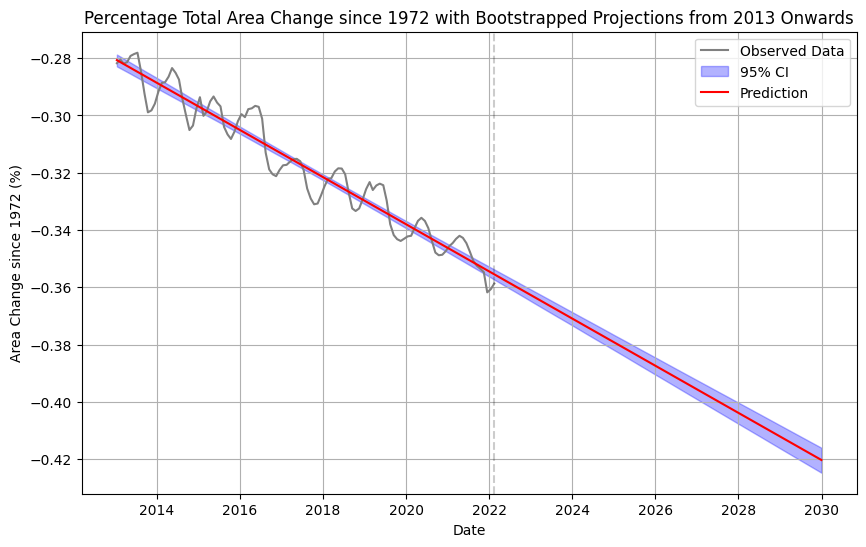

In [127]:
# 2013 onwards for future projections with bootstrap confidence intervals

# set future dates
future_dates = pd.date_range(start=pct_loss_2013_2023.index[-1], end='2030-01-01', freq='ME')
plot_dates = pct_loss_2013_2023.index.append(future_dates)

# create linear model
m, b = np.polyfit(mdates.date2num(pct_loss_2013_2023.index), pct_loss_2013_2023.values, 1)
prediction = m*mdates.date2num(plot_dates) + b

# bootstrap for model uncertainty
# draw 1000 bootstrap replicates
x = mdates.date2num(pct_loss_2013_2023.index)
y = pct_loss_2013_2023.values
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x, y, size=1000)

# predict and get confidence intervals
bs_predictions = np.array([bs_slope_reps[i]*mdates.date2num(plot_dates) + bs_intercept_reps[i] for i in range(1000)])
ci_95 = np.percentile(bs_predictions, [2.5, 97.5], axis=0)


# plot bootstrap lines
plt.figure(figsize=(10,6))
plt.plot(pct_loss_2013_2023.index, pct_loss_2013_2023.values, label='Observed Data', color='grey')
plt.fill_between(plot_dates, ci_95[0], ci_95[1], color='blue', alpha=0.3, label='95% CI')
plt.axvline(pct_loss_2013_2023.index[-1], color='black', alpha=0.2, linestyle='--')
plt.plot(plot_dates, prediction, color='red', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972 with Bootstrapped Projections from 2013 Onwards')
plt.grid()
plt.legend()
plt.show()


In [129]:
# stats by 2030
pred_2030 = prediction[-1]
ci_2030 = ci_95[:, -1]
print(f"Area Change in {pct_loss_2013_2023.index[-1].year}: {pct_loss_2013_2023.values[-1]:.4f}%")
print(f"Projected area Change by 2030: {pred_2030:.4f}%")
print(f"95% CI for 2030: [{ci_2030[0]:.4f}%, {ci_2030[1]:.4f}%]")

Area Change in 2022: -0.3587%
Projected area Change by 2030: -0.4203%
95% CI for 2030: [-0.4247%, -0.4160%]


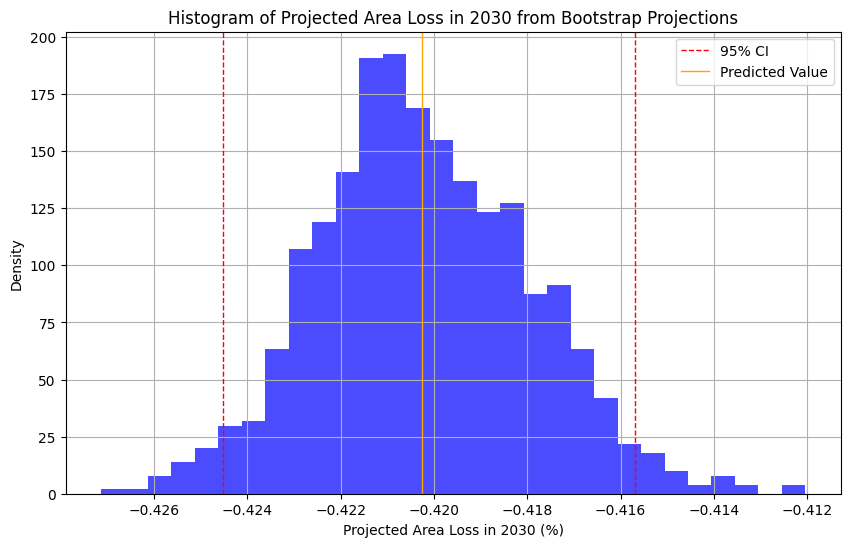

In [114]:
# histogram of area loss in 2030 from bootstrap projections with 95% CI
plt.figure(figsize=(10,6))
plt.hist(bs_predictions[:, -1], bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Projected Area Loss in 2030 (%)')
plt.ylabel('Density')
plt.title('Histogram of Projected Area Loss in 2030 from Bootstrap Projections')
plt.axvline(ci_95[0, -1], color='red', linestyle='dashed', linewidth=1, label='95% CI')
plt.axvline(ci_95[1, -1], color='red', linestyle='dashed', linewidth=1)
plt.axvline(prediction[-1], color='Orange', linestyle='solid', linewidth=1, label='Predicted Value')
plt.grid()
plt.legend()
plt.show()

Below is claude method using residual bootstrapping

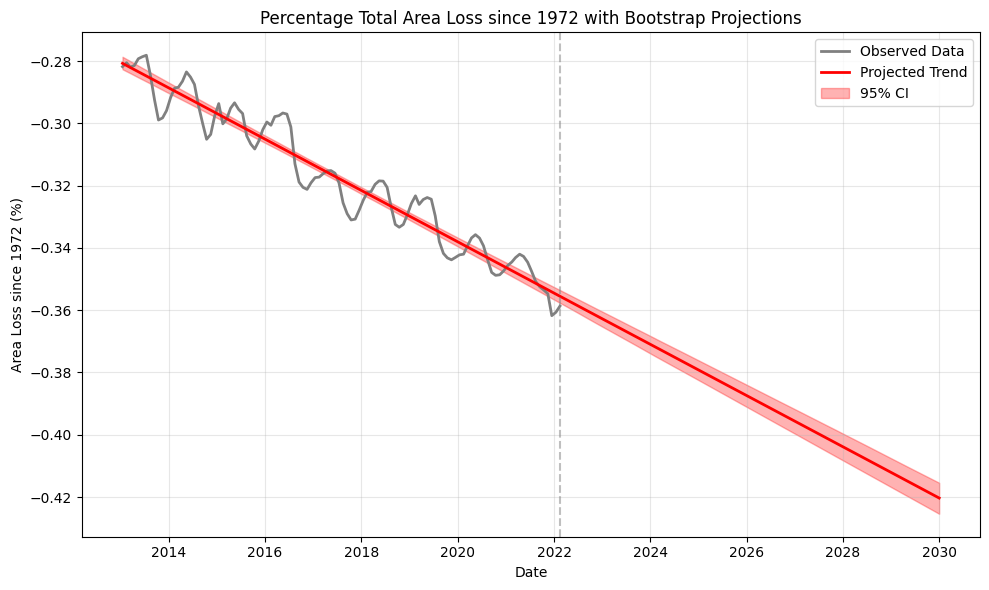

In [87]:
# x and y for data in time period
x = mdates.date2num(pct_loss_2013_2023.index)
y = pct_loss_2013_2023.values

# Linear regression
slope, intercept = np.polyfit(x, y, 1)

# Calculate residuals
fitted = slope * x + intercept
residuals = y - fitted

# Future dates
future_dates = pd.date_range(start=pct_loss_2013_2023.index[-1], end='2030-01-01', freq='ME')
plot_dates = pct_loss_2013_2023.index.append(future_dates)
plot_x = mdates.date2num(plot_dates)

# Bootstrap parameters by resampling residuals
n_bootstrap = 1000
bs_predictions = []

for i in range(n_bootstrap):
    # Resample residuals with replacement
    bs_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    bs_y = fitted + bs_residuals
    
    # Fit new line to bootstrapped data
    bs_slope, bs_intercept = np.polyfit(x, bs_y, 1)
    
    # Project into future
    bs_pred = bs_slope * plot_x + bs_intercept
    bs_predictions.append(bs_pred)

bs_predictions = np.array(bs_predictions)

# Calculate percentiles for confidence bands
lower = np.percentile(bs_predictions, 2.5, axis=0)
upper = np.percentile(bs_predictions, 97.5, axis=0)
median = np.percentile(bs_predictions, 50, axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pct_loss_2013_2023.index, y, label='Observed Data', color='gray', linewidth=2)
plt.plot(plot_dates, median, label='Projected Trend', color='red', linewidth=2)
plt.fill_between(plot_dates, lower, upper, alpha=0.3, color='red', label='95% CI')
plt.axvline(pct_loss_2013_2023.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Area Loss since 1972 (%)')
plt.title('Percentage Total Area Loss since 1972 with Bootstrap Projections')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

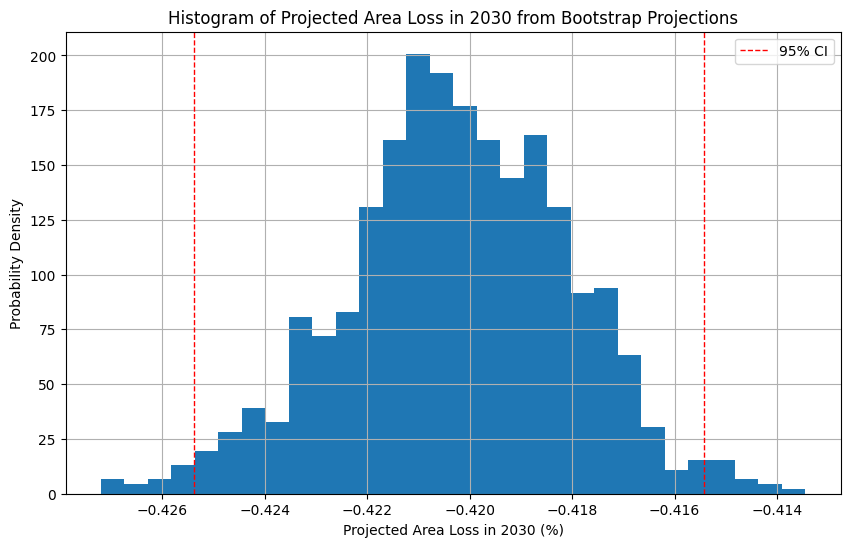

In [110]:
plt.figure(figsize=(10,6))
plt.hist(bs_predictions[:, -1], bins=30, density=True)
plt.axvline(lower[-1], color='red', linestyle='dashed', linewidth=1, label='95% CI')
plt.axvline(upper[-1], color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Projected Area Loss in 2030 (%)')
plt.ylabel('Probability Density')
plt.title('Histogram of Projected Area Loss in 2030 from Bootstrap Projections')
plt.grid()
plt.legend()
plt.show()